In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from matplotlib import image
from sklearn.cross_decomposition import PLSRegression
from helper import *
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from feature_selection import filter_omics
# Suppress warnings
import warnings
from sklearn.metrics import roc_curve, auc
from feature_selection import venn_diagram
warnings.filterwarnings('ignore')

In [10]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xlsx"
xls = pd.ExcelFile(path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")

lipidomics_train, lipidomics_test = get_train_test_split_dataset(lipidomics)
metabolomics_train, metabolomics_test = get_train_test_split_dataset(metabolomics)
proteomics_train, proteomics_test = get_train_test_split_dataset(proteomics)

Y_train = metabolomics_train["TwoClass"]
Y_test = metabolomics_test["TwoClass"]

mapping = {1: 0, 2: 1}
if 2 in np.unique(Y_train):
    Y_train = Y_train.map(mapping)
    Y_test = Y_test.map(mapping)

Training set shape:  (58, 581)
Testing set shape:  (38, 581)
Training set shape:  (58, 216)
Testing set shape:  (38, 216)
Training set shape:  (58, 323)
Testing set shape:  (38, 323)


In [4]:
%load_ext rpy2.ipython

### Obtaining the Input Data

In [17]:
%%R -i lipidomics_train -i lipidomics_test -i metabolomics_train -i metabolomics_test -i proteomics_train -i proteomics_test

library(readxl) 
library(mixOmics)
library(reshape2)

X.train <- list(
  Metabolomics = metabolomics_train,
  Lipidomics = lipidomics_train,
  Proteomics = proteomics_train
)

X.test <- list(
  Metabolomics = metabolomics_test,
  Lipidomics = lipidomics_test,
  Proteomics = proteomics_test
)

sapply(X.train, nrow)

Metabolomics   Lipidomics   Proteomics 
          58           58           58 


Creating the Design Matrix

In [22]:
%%R
names <- c("Metabolomics", "Lipidomics", "Proteomics")
RELATIONSHIP_STRENGTH <- 0.1

design = matrix(
  RELATIONSHIP_STRENGTH, ncol=3, nrow=3, 
  dimnames = list(names, names)
)
diag(design) = 0 # set diagonal to 0s

print(design)

basic.diablo.model = block.splsda(
  X=X.train, Y=Y_train, ncomp=10, design=design
) 

             Metabolomics Lipidomics Proteomics
Metabolomics          0.0        0.1        0.1
Lipidomics            0.1        0.0        0.1
Proteomics            0.1        0.1        0.0


Design matrix has changed to include Y; each block will be
            linked to Y.


Tuning the initial model

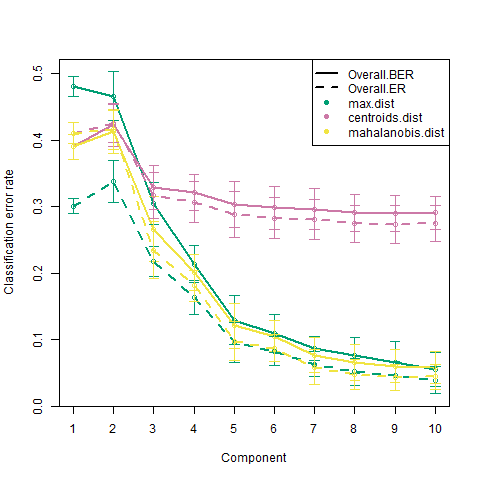

In [24]:
%%R
perf.diablo = perf(
  basic.diablo.model, validation = 'Mfold', progressBar = FALSE,
  dist='all', folds = 10, nrepeat = 20) 

# Plot the output of tuning
plot(perf.diablo, col = color.mixo(4:6)) 

In [38]:
%%R
print(perf.diablo$choice.ncomp$WeightedVote)

# Get the number of components according to BER and Mahalanobis distance
ncomp <- perf.diablo$choice.ncomp$WeightedVote[2,3]
print(ncomp)

            max.dist centroids.dist mahalanobis.dist
Overall.ER         9              5                7
Overall.BER        9              6                7
[1] 7


Design matrix has changed to include Y; each block will be
            linked to Y.


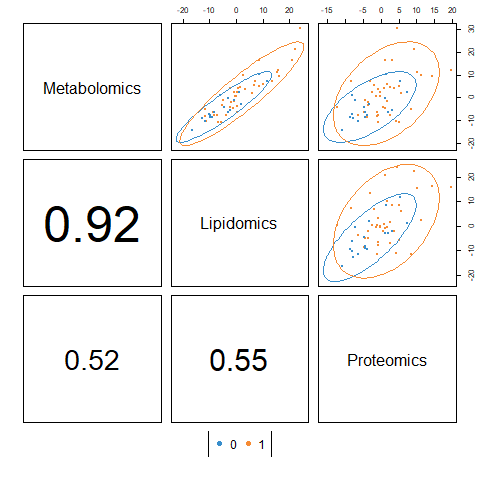

In [44]:
%%R
final.diablo.model = block.splsda(
   X=X.train, Y=Y_train, 
   design=design, ncomp = ncomp
)
plotDiablo(final.diablo.model, ncomp = 1)

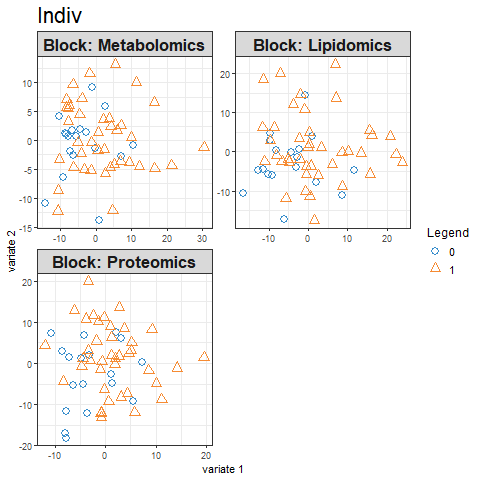

In [46]:
%%R
plotIndiv(final.diablo.model, ind.names = FALSE, legend = TRUE, title = 'Indiv')

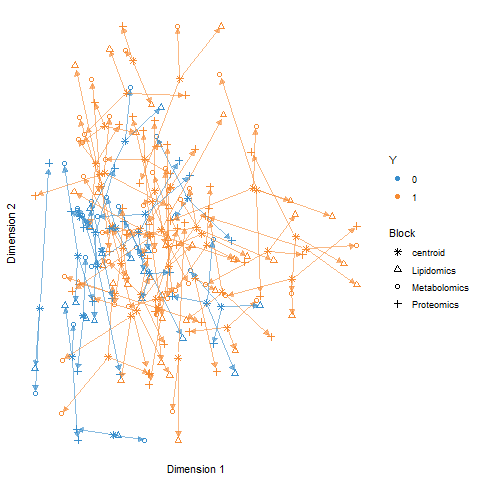

In [47]:
%%R
plotArrow(final.diablo.model, ind.names = FALSE, legend = TRUE, 
          title = 'DIABLO')